In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_titanic_data
from prepare import prep_split_titanic_drp_age,prep_split_titanic_imp_age,prep_split_titanic_drp_null_age
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Logistic Regression

What is it?
- a machine learning algorithm used for predicting categorical target variables
- Pipeline: Plan - Acquire - Prepare - Explore - **Model** - Deliver

Why do we care?
- we can predict future target variables based on the model we build! 

How do we use it?
- acquire, prepare, explore our data
- split data for modeling
- build models on train
    - create rules based on our input data
- evaluate models on train & validate
    - see how our rules work on unseen data
- pick best of the best model, and evaluate bestest model on test

### change hyperparameter
#### Regularization:
- Keep model simple
- Constraints the coefficients


#### C = Inverse of regularization strength:

- Lower C is higher regularization
- Lower C discourages learning more complex model

## Exercises
work with `titanic`data

In [2]:
df = get_titanic_data()
# tr,v,t = prep_split_titanic_drp_age(df)
# tr,v,t = prep_split_titanic_imp_age(df)
tr,v,t = prep_split_titanic_drp_null_age(df)
tr.sample()

csv file found and loaded
data cleaned and prepped
data split
train -> (428, 12); 59.94%
validate -> (143, 12); 20.03%
test -> (143, 12); 20.03%


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
195,1,1,female,58.0,0,0,146.5208,C,1,0,0,0


In [3]:
Xtr = tr.drop(columns=['survived','sex','embarked'])
Xv = v.drop(columns=['survived','sex','embarked'])
Xt = t.drop(columns=['survived','sex','embarked'])
ytr = tr.survived
yv = v.survived
yt = t.survived

In [4]:
# 0 (not survived) most common
# drp_null_age baseline = 0.5934579439252337
def baseline(ytr):
    b = (ytr==ytr.value_counts().idxmax()).mean()
    return b, ytr.value_counts().idxmax()
baseline(ytr)

(0.5934579439252337, 0)

### 1. Create a model that includes only age, fare, and pclass. Does this model perform better than your baseline?



In [5]:
features = ['age','fare','pclass']

In [6]:
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])

In [7]:
l.coef_,Xtr[features].columns

(array([[-0.04438556,  0.00750615, -1.04081893]]),
 Index(['age', 'fare', 'pclass'], dtype='object'))

In [8]:
l.score(Xtr[features],ytr)

0.7149532710280374

In [9]:
def cmd(ytr,y_pred,labels=l.classes_):
    ConfusionMatrixDisplay(confusion_matrix(ytr,y_pred,labels=labels),display_labels=labels).plot()
    plt.show()

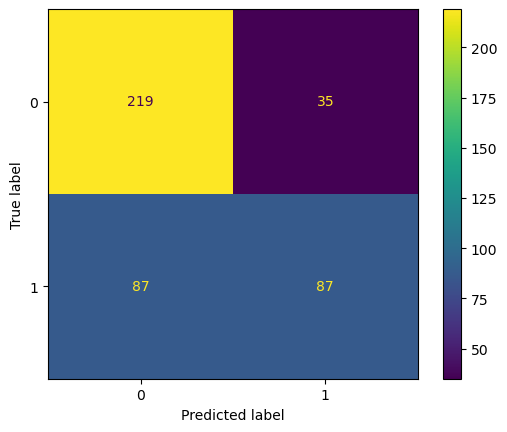

In [10]:
cmd(ytr,ytr_pred)

In [11]:
pd.DataFrame(classification_report(ytr,ytr_pred,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.715686,0.713115,0.714953,0.714401,0.714641
recall,0.862205,0.500000,0.714953,0.681102,0.714953
f1-score,0.782143,0.587838,0.714953,0.684990,0.703150
support,254.000000,174.000000,0.714953,428.000000,428.000000


In [12]:
# drp_null_age baseline acc = 0.5934579439252337
# drp_null_age[age,fare,pclass] acc = 0.7149532710280374
baseline(ytr),l.score(Xtr[features],ytr)

((0.5934579439252337, 0), 0.7149532710280374)

### 2. Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.



In [13]:
features = ['age','fare','pclass','sex_male']

In [14]:
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])

In [15]:
l.coef_,Xtr[features].columns

(array([[-0.03940784,  0.00325799, -1.09151249, -2.2331381 ]]),
 Index(['age', 'fare', 'pclass', 'sex_male'], dtype='object'))

In [16]:
l.score(Xtr[features],ytr)

0.8037383177570093

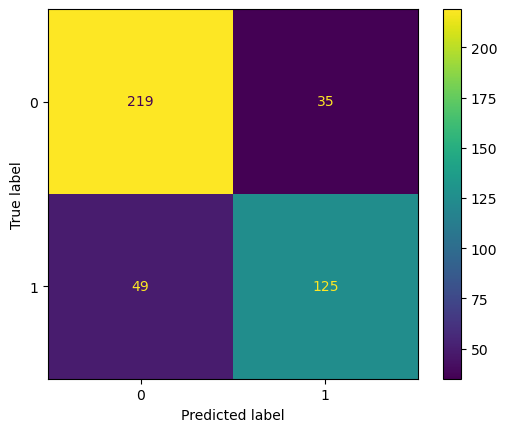

In [17]:
cmd(ytr,ytr_pred)

In [18]:
pd.DataFrame(classification_report(ytr,ytr_pred,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.817164,0.781250,0.803738,0.799207,0.802564
recall,0.862205,0.718391,0.803738,0.790298,0.803738
f1-score,0.839080,0.748503,0.803738,0.793792,0.802257
support,254.000000,174.000000,0.803738,428.000000,428.000000


In [19]:
# drp_null_age baseline acc = 0.5934579439252337
# drp_null_age[age,fare,pclass,sex_male] acc = 0.8037383177570093
baseline(ytr),l.score(Xtr[features],ytr)

((0.5934579439252337, 0), 0.8037383177570093)

### 3. Try out other combinations of features and models.



In [20]:
import itertools

In [21]:
def feature_combos(Xtr,ytr,max_iter=100):
    metrics = []
    iterable = Xtr.columns.to_list()
    for r in range(2,(len(iterable)+1)):
        for feature in itertools.combinations(iterable,r):
            f = list(feature)
            l = LogisticRegression(random_state=42,max_iter=max_iter)
            l.fit(Xtr[f],ytr)
            ytr_score = l.score(Xtr[f],ytr)
            # table-ize
            output = {
                'features':f,
                'train_score':ytr_score,
            }
            metrics.append(output)
    return pd.DataFrame(metrics)

In [22]:
df = feature_combos(Xtr,ytr,250)

In [23]:
f = df.sort_values('train_score',ascending=False).head(3)['features']
f

463    [pclass, age, sibsp, parch, alone, sex_male, e...
376         [pclass, age, sibsp, parch, alone, sex_male]
496    [pclass, age, sibsp, parch, alone, sex_male, e...
Name: features, dtype: object

In [24]:
f[463]

['pclass', 'age', 'sibsp', 'parch', 'alone', 'sex_male', 'embarked_S']

In [25]:
f[376]

['pclass', 'age', 'sibsp', 'parch', 'alone', 'sex_male']

In [26]:
f[496]

['pclass',
 'age',
 'sibsp',
 'parch',
 'alone',
 'sex_male',
 'embarked_Q',
 'embarked_S']

### 4. Use you best 3 models to predict and evaluate on your validate sample.



In [27]:
metrics = []
for i in [f[376],f[463],f[496]]:
    l = LogisticRegression(random_state=42,max_iter=250)
    l.fit(Xtr[i],ytr)
    ytr_score = l.score(Xtr[i],ytr)
    yv_score = l.score(Xv[i],yv)
    # table-ize
    output = {
        'features':i,
        'train_score':ytr_score,
        'val_score':yv_score,
    }
    metrics.append(output)
pd.DataFrame(metrics)

,features,train_score,val_score
0,"[pclass, age, sibsp, parch, alone, sex_male]",0.813084,0.783217
1,"[pclass, age, sibsp, parch, alone, sex_male, e...",0.813084,0.790210
2,"[pclass, age, sibsp, parch, alone, sex_male, e...",0.813084,0.790210


### 5. Choose you best model from the validation performance, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

In [28]:
def l_scores(Xtr, ytr, Xv, yv, max_iter=100):
    #define variables
    metrics = []
    iterable = Xtr.columns.to_list()
    for r in range(2,(len(iterable)+1)):
        for feature in itertools.combinations(iterable,r):
            f = list(feature)
            l = LogisticRegression(random_state=42,max_iter=max_iter)
            l.fit(Xtr[f],ytr)
            ytr_score = l.score(Xtr[f],ytr)
            yv_score = l.score(Xv[f],yv)
            # table-ize
            output = {
                'features':f,
                'train_score':ytr_score,
                'val_score':yv_score,
            }
            metrics.append(output)
    #Put results into a dataframe
    df = pd.DataFrame(metrics)
    # Calculate the difference between the train and validation scores
    df['diff_score'] = abs(df.train_score - df.val_score)
    df['avg_score'] = (df.train_score + df.val_score)/2
    return df

def score_plot(data, diff=0.1, score='avg_score', score_v=.7):
    df = data[(data.diff_score<diff)&(data[score]>score_v)].sort_values([score, 'diff_score'], ascending=[False, True]).reset_index()
    df = df.drop(columns='index')
    # plot
    plt.figure(figsize=(8, 5))
    plt.plot(df.index, df.train_score, label='train', marker='o', color='blue')
    plt.plot(df.index, df.val_score, label='validation', marker='o', color='orange')
    plt.fill_between(df.index, df.train_score, df.val_score, alpha=0.2, color='gray')
    plt.plot(df.index, df.avg_score, label='avg_score', marker='o', color='black')
    plt.xlabel('index', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Random Forest Classifier Performance', fontsize=18)
    plt.legend(fontsize=12)
    plt.show()
    return df

In [29]:
df = l_scores(Xtr,ytr,Xv,yv,250)

In [30]:
df.sample()

,features,train_score,val_score,diff_score,avg_score
410,"[pclass, sibsp, parch, fare, sex_male, embarke...",0.785047,0.755245,0.029802,0.770146


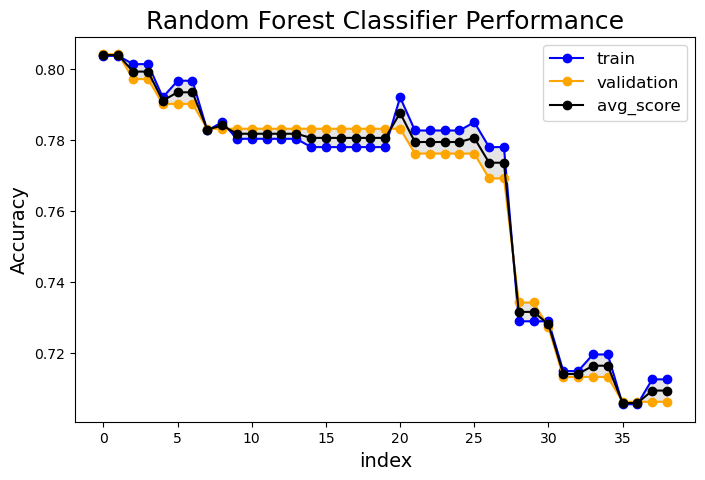

,features,train_score,val_score,diff_score,avg_score
0,"[pclass, age, alone, sex_male]",0.803738,0.804196,0.000457,0.803967
1,"[pclass, age, alone, sex_male, embarked_Q]",0.803738,0.804196,0.000457,0.803967
2,"[pclass, age, sex_male]",0.801402,0.797203,0.004199,0.799302
3,"[pclass, age, sex_male, embarked_Q]",0.801402,0.797203,0.004199,0.799302
4,"[pclass, sibsp, alone, sex_male, embarked_Q, e...",0.792056,0.790210,0.001846,0.791133
5,"[pclass, sibsp, parch, alone, sex_male, embark...",0.796729,0.790210,0.006519,0.793469
6,"[pclass, sibsp, parch, alone, sex_male, embark...",0.796729,0.790210,0.006519,0.793469
7,"[age, sibsp, alone, sex_male, embarked_Q, emba...",0.782710,0.783217,0.000507,0.782964
8,"[pclass, sibsp, parch, alone, sex_male, embark...",0.785047,0.783217,0.001830,0.784132
9,"[pclass, sibsp, sex_male, embarked_S]",0.780374,0.783217,0.002843,0.781795


In [31]:
score_plot(df,0.01,'val_score')

In [32]:
f = ['pclass', 'age', 'alone', 'sex_male']
l_test = LogisticRegression(random_state=42)
l_test.fit(Xtr[f],ytr)
baseline(ytr),l_test.score(Xtr[f],ytr),l_test.score(Xv[f],yv),l_test.score(Xt[f],yt)

((0.5934579439252337, 0),
 0.8037383177570093,
 0.8041958041958042,
 0.7972027972027972)

### **Bonus1** How do different strategies for handling the missing values in the age column affect model performance?

In [33]:
df = get_titanic_data()
# tr,v,t = prep_split_titanic_drp_age(df)
tr,v,t = prep_split_titanic_imp_age(df)
# tr,v,t = prep_split_titanic_drp_null_age(df)
tr.sample()

csv file found and loaded
data cleaned and prepped
data split
train -> (534, 12); 59.93%
validate -> (178, 12); 19.98%
test -> (179, 12); 20.09%


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
605,0,3,male,36.0,1,0,15.55,S,0,1,0,1


In [34]:
Xtr = tr.drop(columns=['survived','sex','embarked'])
Xv = v.drop(columns=['survived','sex','embarked'])
Xt = t.drop(columns=['survived','sex','embarked'])
ytr = tr.survived
yv = v.survived
yt = t.survived

In [35]:
# impute_age baseline = 0.6161048689138576
baseline(ytr)

(0.6161048689138576, 0)

In [36]:
features = ['age','fare','pclass']
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])
l.score(Xtr[features],ytr)

0.7116104868913857

In [37]:
Xtr['age'].mean(),Xtr['age'].median()

(30.047010354703644, 29.69911764705882)